# Load dependencies

In [1]:
#load dependencies
#load in dependencies to read data
using CSV, Plots, DataFrames, Dates
using LinearAlgebra,Pkg
#using DifferentialEquations # do not need the whole package necessarilly. Using just the ODE functions will save some memory
using OrdinaryDiffEq
#show versions
Pkg.status()

    Status `C:\Users\Steve\.julia\environments\v1.3\Project.toml`
  [336ed68f] CSV v0.5.26
  [a93c6f00] DataFrames v0.20.2
  [aae7a2af] DiffEqFlux v1.3.2
  [0c46a032] DifferentialEquations v6.10.1
  [587475ba] Flux v0.10.1
  [7073ff75] IJulia v1.21.1
  [c601a237] Interact v0.10.3
  [b964fa9f] LaTeXStrings v1.1.0
  [47be7bcc] ORCA v0.3.1
  [429524aa] Optim v0.20.1
  [1dea7af3] OrdinaryDiffEq v5.34.1
  [f0f68f2c] PlotlyJS v0.13.1
  [91a5bcdd] Plots v0.28.4
  [d330b81b] PyPlot v2.8.2
  [6f49c342] RCall v0.13.4
  [90137ffa] StaticArrays v0.12.1
  [f3b207a7] StatsPlots v0.14.2
  [fd094767] Suppressor v0.1.1
  [fce5fe82] Turing v0.8.3
  [30578b45] URIParser v0.4.0
  [0ae4a718] VegaDatasets v2.0.0
  [112f6efa] VegaLite v2.0.1
  [0f1e0344] WebIO v0.8.13
  [fdbf4ff8] XLSX v0.6.0


In [2]:
versioninfo()

Julia Version 1.3.1
Commit 2d5741174c (2019-12-30 21:36 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


# Spatial Epidemic Model for GA for COVID-19

Here, we extend the model to look at infection spread through a spatial metapopulation model.
To do this, we consider that individuals spend time in the local community, but also may commute - for work, errands, social activities or other things. Following this we split the population $N_{tot}$ into two compartments $N_{local}$ and $N_{commute}$. $N_{local}$ is the population who live in a particular county, whilst $N_{commute} = N_{local} - N_{leave} + N_{arrive}$. Here $N_{leave}$ are those who leave the county, whilst $N_{arrive}$ are those who travel into the county. We do not explicitly account for those arriving or leaving in the local ODE's.

We assume that those in the county see the local population for a proportion of time $w_{local}$ and the commuter population for a proportion of time $w_{commmute}$, where we assume $w_{local} + w_{commute} = 1$.


The system of nonlinear differential equations governing this patch and age-structured epidemiological for patch $i$ and age $a$ are as follows:

\begin{align}
\frac{dS(i,a)}{dt} & =  -\overset{new\ cases\ from\ symptomatic\ contact}{\overbrace{\kappa\beta_S S(i,a) \left( w_{local}\frac{ I_{S,local}(i)}{N_{local}(i)} + w_{commute}\frac{ I_{S,commute}(i)}{N_{commute}(i)} \right) }}  - \overset{new\ cases\ from\ asymptomatic\ contact}{\overbrace{\kappa\beta_A S(i,a) \left( w_{local}\frac{ I_{A,local}(i)}{N_{local}(i)} + w_{commute}\frac{ I_{A,commute}(i)}{N_{commute}(i)} \right) }}  \\ \\
\frac{dE(i,a)}{dt} & =  \overset{new\ cases\ from\ symptomatic\ contact}{\overbrace{\kappa\beta_S S(i,a) \left( w_{local}\frac{ I_{S,local}(i)}{N_{local}(i)} + w_{commute}\frac{ I_{S,commute}(i)}{N_{commute}(i)} \right) }}  + \overset{new\ cases\ from\ asymptomatic\ contact}{\overbrace{\kappa\beta_A S(i,a) \left( w_{local}\frac{ I_{A,local}(i)}{N_{local}(i))} + w_{commute}\frac{ I_{A,commute}(i)}{N_{commute}(i)} \right) }}  - \overset{onset\ of\ infectiousness}{\overbrace{\gamma_E E(i,a)}} \\
\frac{dI_A(i,a)}{dt} & =  \overset{asymptomatic\ onset}{\overbrace{p\gamma_E E(i,a)}} - \overset{recovery}{\overbrace{\gamma_A I_A(i,a)}} \\
\frac{dI_S(i,a)}{dt} & =  \overset{symptomatic\ onset}{\overbrace{(1-p)\gamma_E E(i,a)}} - \overset{transfer\ from\ I_S}{\overbrace{\gamma_S I_S(i,a)}} \\
\frac{dI_{h,sub}(i,a)}{dt} & =  \overset{subcritical\ cases}{\overbrace{h(a)(1-\xi(a)) \gamma_S I_S(i,a)}} - \overset{transfer\ from\ I_{h,sub}}{\overbrace{\gamma_h I_{h,sub}(i,a)}} \\
\frac{dI_{h,crit}(i,a)}{dt} & =  \overset{critical\ (ICU)\ cases}{\overbrace{h(a)\xi(a) \gamma_S I_S(i,a)}} - \overset{transfer\ from\ I_{h,crit}}{\overbrace{\gamma_h I_{h,crit}(i,a)}} \\
\frac{dR(a)}{dt} & =  \overset{recovery\ from\ I_A}{\overbrace{\gamma_A I_A(i,a)}} + \overset{recovery\ from\ I_S}{\overbrace{(1-h(a))\gamma_S I_S(i,a)}} + \overset{recovery\ from\ I_{h,sub}}{\overbrace{\gamma_h I_{h,sub}(i,a)}} + \overset{recovery\ from\ I_{h,crit}}{\overbrace{(1-\mu)\gamma_h I_{h,crit}(i,a)}} \\
\frac{dD(i,a)}{dt} & = \overset{mortality}{\overbrace{\mu \gamma_h I_{h,crit}(i,a)}}
\end{align}

where $I_{S,local}$ and $I_{S,commute}$ are the total number (across all age classes) of sympomatic infectious individuals; $I_{A,local}$ and $I_{S,commute}$ are the total number of asymptomatic infectious individuals; and $N_{local}$ and $N_{commute}$ are the total number of alive individuals during local and commute times.

# Read in functions called in the scripts

In [3]:
#ODE model code
#assumes age-dependent journeys between counties
function SpatialAgeStructuredEpidemiologicalModelMixAge!(du,u,par,t)
    SDI,β_a,β_s,p,γ_e,γ_a,γ_s,γ_h,h,ξ,μ,S_ind,E_ind,
    Ia_ind,Is_ind,Ihsub_ind,Ihcrit_ind,R_ind,D_ind,T_Hosp_ind,
    NumPatches,NumAgeClasses,patchstates,patchstatesALIVE,
    patchstatesMOVEABLE,w,wy,wo,transport,ISMOVEFACTOR,w1,w2 = par
    
    #NumPatches is the number of spatial "nodes"
    #w is a matrix of size NxN determining flows between nodes.
    #transport is a matrix to store movements vectors (don't want to recreate this object throughout this function)
    #patchstates - total number of states in a patch
    #patchstatesALIVE - number of non-dead states
    #patchstatesMOVEABLE - number of states that are allowed to move between patches
    #S_ind,E_ind,Ia_ind,Is_ind,Ihsub_ind,Ihcrit_ind,R_ind,D_ind - indexes of the states for the first patch i.e. number 1:80

    
    #have matrix w, representing movement of commuters i.e. X1 stay in county, X2 go to county 2, X3 go to county3
    #total travel is fraction travelled applied to people in moving states
    #some amounts of these will be IA and IS - keep track!
    #want to know N,Is,IA leaving each county; and arriving at each county
    #w11 S1 + w12 S2  #net change for each state so long as diagonal is -ve.

    #w is those aged 30-59
    #wy is those 0-29
    #wo is those 60+
    
    #Stage 1:
    #calculate transport between patches
    
    #transport = transport .* 0.0;
    #want this to be age structured
    for ii = 1:patchstatesMOVEABLE #for each age class of alive states that can move.
        INDS = ii:patchstates:(ii+(NumPatches-1)*patchstates ) #gives 1xpatch indices for transport multiplication for each age class and each state that can move
        MOD = mod(ii,NumAgeClasses-1)
        if MOD>0 & MOD<4
        transport[:,ii] = wy*u[INDS] 
        elseif MOD==0  || MOD >=7
        transport[:,ii] = wo*u[INDS]
        else
        transport[:,ii] =  w*u[INDS]  #add the 1*patch vector of movement fluxes to transport
        end
    end
    
    #modify tranport matrix to account for Is people deciding to move or not.
    transport[:,Is_ind] = ISMOVEFACTOR .* transport[:,Is_ind]

    #calculate net change for each patch for N,Ia and Is
    C_TOT_NETCHANGE = sum(transport,dims=2)
    C_I_A_NETCHANGE = sum(transport[:,Ia_ind],dims=2)
    C_I_S_NETCHANGE = sum(transport[:,Is_ind],dims=2)
    
    #Stage 2:
    #Go through the ODE system node by node. As have found fluxes between nodes already, this will be a synchronous update of local and spatial dynamics.

    for aa=1:(Int64(NumPatches)) #for each patch node
        
        #Local patch dynamics depend on patch quantitites
        NTOT_Loc = sum(u[((aa-1)*patchstates+1):((aa-1)*patchstates+patchstatesALIVE)]) #total alive
        TOTI_a_Loc = sum(u[(aa-1)*patchstates .+ Ia_ind]) #total asymptomatic infected
        TOTI_s_Loc = sum(u[(aa-1)*patchstates .+ Is_ind]) #total symptomatic infected
        
        NTOT_Com = NTOT_Loc + C_TOT_NETCHANGE[aa]#total alive
        TOTI_a_Com = TOTI_a_Loc + C_I_A_NETCHANGE[aa] #total asymptomatic infected
        TOTI_s_Com = TOTI_s_Loc + C_I_S_NETCHANGE[aa] #total symptomatic infected
        
        LOCAL = w1/(NTOT_Loc)
        COMMUTE = w2/(NTOT_Com)
        propI_A = ( TOTI_a_Loc*LOCAL + TOTI_a_Com*COMMUTE )
        propI_S = ( TOTI_s_Loc*LOCAL + TOTI_s_Com*COMMUTE )
        
        
        for bb = 1:(Int64(NumAgeClasses))  #for each age class in this patch
        INDS = (aa-1)*patchstates .+ [S_ind[bb],E_ind[bb],Ia_ind[bb],Is_ind[bb],R_ind[bb],Ihsub_ind[bb],Ihcrit_ind[bb],D_ind[bb],T_Hosp_ind[bb]]   
            
            
            S,E,Ia,Is,R,Ihsub,Ihcrit,D = u[INDS]

            du[INDS[1]] =  -β_a*SDI*S*propI_A - β_s*SDI*S*propI_S   #dS/dt
            du[INDS[2]] =  +β_a*SDI*S*propI_A + β_s*SDI*S*propI_S - γ_e*E  #dE/dt
            du[INDS[3]] = p[bb]*γ_e*E - γ_a*Ia   #dI_a /dt
            du[INDS[4]] = (1-p[bb])*γ_e*E - γ_s*Is  #dI_s/dt
            du[INDS[5]] = γ_a*Ia + (1-h[bb])*γ_s*Is + γ_h*Ihsub + (1-μ[bb])*γ_h*Ihcrit #dR/dt
            du[INDS[6]] = h[bb]*(1-ξ[bb])*γ_s*Is - γ_h*Ihsub #dIhsub/dt
            du[INDS[7]] = h[bb]*ξ[bb]*γ_s*Is -  γ_h*Ihcrit #dIhcrit/dt
            du[INDS[8]] = μ[bb]*γ_h*Ihcrit #dD/dt
            du[INDS[9]] = h[bb]*γ_s*Is  #tot Hosp
        end
    end
    
end


SpatialAgeStructuredEpidemiologicalModelMixAge! (generic function with 1 method)

In [4]:
#ODE model code - this is used to model at the level of the whole of Georgia! (helpful in setting initial conditions)
function SingleNode!(du,u,par,t)
    SDI,β_a,β_s,p,γ_e,γ_a,γ_s,γ_h,h,ξ,μ,S_ind,E_ind,Ia_ind,Is_ind,R_ind,Ihsub_ind,Ihcrit_ind,D_ind,T_Hosp_ind = par
    
    TOTI_a = sum(u[Ia_ind]) #Total asymptomatic infectious individuals
    TOTI_s = sum(u[Is_ind]) #Total symptomatic infectious individuals
    NTOT = sum(u[1:63]) #All individuals not in the dead (D) state

    
    for aa = 1:length(S_ind)#for each age class
        INDS = [S_ind[aa],E_ind[aa],Ia_ind[aa],Is_ind[aa],R_ind[aa],Ihsub_ind[aa],Ihcrit_ind[aa],D_ind[aa],T_Hosp_ind[aa]]
        S,E,Ia,Is,R,Ihsub,Ihcrit,D = u[INDS]
        du[INDS[1]] = -β_a*SDI*S*TOTI_a/(NTOT) - β_s*SDI*S*TOTI_s/(NTOT) #dS/dt
        du[INDS[2]] = +β_a*SDI*S*TOTI_a/(NTOT) + β_s*SDI*S*TOTI_s/(NTOT) -  γ_e*E   #dE/dt
        du[INDS[3]] = p[aa]*γ_e*E - γ_a*Ia  #dI_a /dt
        du[INDS[4]] = (1-p[aa])*γ_e*E - γ_s*Is  #dI_s/dt
        du[INDS[5]] = γ_a*Ia + (1-h[aa])*γ_s*Is + γ_h*Ihsub + (1-μ[aa])*γ_h*Ihcrit  #dR/dt
        du[INDS[6]] = h[aa]*(1-ξ[aa])*γ_s*Is - γ_h*Ihsub #dIhsub/dt
        du[INDS[7]] = h[aa]*ξ[aa]*γ_s*Is -  γ_h*Ihcrit #dIhcrit/dt
        du[INDS[8]] = μ[aa]*γ_h*Ihcrit #dD/dt
        du[INDS[9]] = h[aa]*γ_s*Is #Cumulative hospitalised
    end
 
end

SingleNode! (generic function with 1 method)

In [5]:
#reads in ODE solution; and saves output summary figures and CSV files
function WriteOutput!(PatchFIPS,PatchNames,Regions,GAPOP,TODAY,TIMERESOLTION,T_END,sol,pars,SaveName)

    Gath = gatherStates!(sol,pars)
    STATES = GAPOP * Gath[1] #organise the solution
    Times = sol.t[Gath[2]]
        
    
    #patches  x EpiStates x AgeClasses x Time
    SIZES = size(STATES) 
    
    #Make summary tables for each epi state, and total hospitalised
    #S,E,Ia,Is,R,Ihsub,Ihcrit,D, Ihsub+Ihcrit
    S = zeros(SIZES[1],SIZES[4]) # patches x time
    E = zeros(SIZES[1],SIZES[4]) # patches x time
    Ia = zeros(SIZES[1],SIZES[4]) # patches x time
    Is = zeros(SIZES[1],SIZES[4]) # patches x time
    R = zeros(SIZES[1],SIZES[4]) # patches x time
    Ihsub = zeros(SIZES[1],SIZES[4]) # patches x time
    Ihcrit = zeros(SIZES[1],SIZES[4]) # patches x time
    D = zeros(SIZES[1],SIZES[4]) # patches x time
    Htot = zeros(SIZES[1],SIZES[4]) # patches x time
    Dperday = zeros(SIZES[1],SIZES[4]) # patches x time
    NewCperday = zeros(SIZES[1],SIZES[4]) # patches x time
    Hcumulative = zeros(SIZES[1],SIZES[4]) # patches x time
    
    for aa = 1:SIZES[1] #for each patch
        S[aa,:] = dropdims(sum(STATES[aa,1,1:9,:],dims=1),dims=1)
        E[aa,:] = dropdims(sum(STATES[aa,2,1:9,:],dims=1),dims=1)
        Ia[aa,:] = dropdims(sum(STATES[aa,3,1:9,:],dims=1),dims=1)
        Is[aa,:] = dropdims(sum(STATES[aa,4,1:9,:],dims=1),dims=1)
        R[aa,:] = dropdims(sum(STATES[aa,5,1:9,:],dims=1),dims=1)
        Ihsub[aa,:] = dropdims(sum(STATES[aa,6,1:9,:],dims=1),dims=1)
        Ihcrit[aa,:] = dropdims(sum(STATES[aa,7,1:9,:],dims=1),dims=1)
        D[aa,:] = dropdims(sum(STATES[aa,8,1:9,:],dims=1),dims=1)
        Htot[aa,:] =  Ihsub[aa,:] .+ Ihcrit[aa,:]
        for bb = 1:SIZES[3] #for age classes
            #Dperday[aa,:] .+=  μ[bb].*γ_h .*STATES[aa,7,bb,:].*1.0;  #deaths per day
            Dperday[aa,:] .+= [( STATES[aa,8,bb,2:end] .- STATES[aa,8,bb,1:(end-1)]) ./ (Times[2:end] - Times[1:(end-1)]); 0]
            NewCperday[aa,:] .+= [( STATES[aa,1,bb,1:(end-1)] .- STATES[aa,1,bb,2:end]) ./ (Times[2:end] - Times[1:(end-1)]); 0]
        end
        Hcumulative[aa,:] = dropdims(sum(STATES[aa,9,1:9,:],dims=1),dims=1)
    end
    
    #build Time column names
    colnames = Array{Date,1}(undef,1)
    colnames[1] = TODAY
    for aa = 2:(SIZES[4])#for each time
        push!(colnames,colnames[aa-1]+Dates.Day(convert(Int,Times[aa]-Times[aa-1])))
    end


    #build dataframes
    SSdata = DataFrame(S)
    rename!(SSdata , Symbol.(colnames))
    insertcols!(SSdata, 1, :FIP => PatchFIPS)
    insertcols!(SSdata, 2, :County => PatchNames)
    
    EEdata = DataFrame(E)
    rename!(EEdata , Symbol.(colnames))
    insertcols!(EEdata, 1, :FIP => PatchFIPS)
    insertcols!(EEdata, 2, :County => PatchNames)
    
    Iadata = DataFrame(Ia)
    rename!(Iadata , Symbol.(colnames))
    insertcols!(Iadata, 1, :FIP => PatchFIPS)
    insertcols!(Iadata, 2, :County => PatchNames)
    
    Isdata = DataFrame(Is)
    rename!(Isdata , Symbol.(colnames))
    insertcols!(Isdata, 1, :FIP => PatchFIPS)
    insertcols!(Isdata, 2, :County => PatchNames)
   
    RRdata = DataFrame(R)
    rename!(RRdata , Symbol.(colnames))
    insertcols!(RRdata, 1, :FIP => PatchFIPS)
    insertcols!(RRdata, 2, :County => PatchNames)
    
    Ihsubdata = DataFrame(Ihsub)
    rename!(Ihsubdata , Symbol.(colnames))
    insertcols!(Ihsubdata, 1, :FIP => PatchFIPS)
    insertcols!(Ihsubdata, 2, :County => PatchNames)
    
    Ihcritdata = DataFrame(Ihcrit)
    rename!(Ihcritdata , Symbol.(colnames))
    insertcols!(Ihcritdata, 1, :FIP => PatchFIPS)
    insertcols!(Ihcritdata, 2, :County => PatchNames)
    
    DDdata = DataFrame(D)
    rename!(DDdata , Symbol.(colnames))
    insertcols!(DDdata, 1, :FIP => PatchFIPS)
    insertcols!(DDdata, 2, :County => PatchNames)
    
    HHdata = DataFrame(Htot)
    rename!(HHdata , Symbol.(colnames))
    insertcols!(HHdata, 1, :FIP => PatchFIPS)
    insertcols!(HHdata, 2, :County => PatchNames)
    
    DpDdata = DataFrame(Dperday)
    rename!(DpDdata , Symbol.(colnames))
    insertcols!(DpDdata, 1, :FIP => PatchFIPS)
    insertcols!(DpDdata, 2, :County => PatchNames)
    
    CpDdata = DataFrame(NewCperday)
    rename!(CpDdata , Symbol.(colnames))
    insertcols!(CpDdata, 1, :FIP => PatchFIPS)
    insertcols!(CpDdata, 2, :County => PatchNames)
    
    Hcumdata = DataFrame(Hcumulative)
    rename!(Hcumdata , Symbol.(colnames))
    insertcols!(Hcumdata, 1, :FIP => PatchFIPS)
    insertcols!(Hcumdata, 2, :County => PatchNames)
    
    #make a directory to store files
    mkdir(SaveName)
    
    #write data to file
    CSV.write(string(SaveName,"/GA_county_Susceptibles.csv"),SSdata)
    CSV.write(string(SaveName,"/GA_county_Exposed.csv"),EEdata)
    CSV.write(string(SaveName,"/GA_county_AsymptInfected.csv"),Iadata)
    CSV.write(string(SaveName,"/GA_county_SymptInfected.csv"),Isdata)
    CSV.write(string(SaveName,"/GA_county_Recovered.csv"),RRdata)
    CSV.write(string(SaveName,"/GA_county_subacuteHospitalised.csv"),Ihsubdata)
    CSV.write(string(SaveName,"/GA_county_criticalHospitalised.csv"),Ihcritdata)
    CSV.write(string(SaveName,"/GA_county_Killed.csv"),DDdata)
    CSV.write(string(SaveName,"/GA_county_totalHospitalised.csv"),HHdata)
    CSV.write(string(SaveName,"/GA_county_deathrateperday.csv"),DpDdata)
    CSV.write(string(SaveName,"/GA_county_newcaserateperday.csv"),CpDdata)
    CSV.write(string(SaveName,"/GA_county_cumulativeHospitalised.csv"),Hcumdata)
    
    ##save summary data at RegionalLevel
    
    RegionList = sort(unique(Regions))
    SSdataR = zeros(length(RegionList),SIZES[4])
    EEdataR = zeros(length(RegionList),SIZES[4])
    IadataR = zeros(length(RegionList),SIZES[4])
    IsdataR = zeros(length(RegionList),SIZES[4])
    IhsubdataR = zeros(length(RegionList),SIZES[4])
    IhcritdataR = zeros(length(RegionList),SIZES[4])
    RRdataR = zeros(length(RegionList),SIZES[4])
    DDdataR = zeros(length(RegionList),SIZES[4])
    HHdataR = zeros(length(RegionList),SIZES[4])
    DpDdataR = zeros(length(RegionList),SIZES[4])
    CpDdataR = zeros(length(RegionList),SIZES[4])
    HcumdataR = zeros(length(RegionList),SIZES[4])
     
    for aa = 1:length(RegionList) #for each region
        RegionInd = findall(Regions.== RegionList[aa])
        SSdataR[aa,:] = sum(S[RegionInd,:],dims=1)
        EEdataR[aa,:] = sum(E[RegionInd,:],dims=1)
        IadataR[aa,:] = sum(Ia[RegionInd,:],dims=1)
        IsdataR[aa,:] = sum(Is[RegionInd,:],dims=1)
        RRdataR[aa,:] = sum(R[RegionInd,:],dims=1)
        DDdataR[aa,:] = sum(D[RegionInd,:],dims=1)
        IhsubdataR[aa,:] = sum(Ihsub[RegionInd,:],dims=1)
        IhcritdataR[aa,:] = sum(Ihcrit[RegionInd,:],dims=1)
        HHdataR[aa,:] = sum(Htot[RegionInd,:],dims=1)
        DpDdataR[aa,:] = sum(Dperday[RegionInd,:],dims=1)
        CpDdataR[aa,:] = sum(NewCperday[RegionInd,:],dims=1)
        HcumdataR[aa,:] = sum(Hcumulative[RegionInd,:],dims=1)
    end
    
    SSdataRR = DataFrame(SSdataR)
    rename!(SSdataRR , Symbol.(colnames))
    insertcols!(SSdataRR, 1, :Region => RegionList)
    
    EEdataRR = DataFrame(EEdataR)
    rename!(EEdataRR , Symbol.(colnames))
    insertcols!(EEdataRR, 1, :Region => RegionList)
    
    IadataRR = DataFrame(IadataR)
    rename!(IadataRR , Symbol.(colnames))
    insertcols!(IadataRR, 1, :Region => RegionList)
    
    IsdataRR = DataFrame(IsdataR)
    rename!(IsdataRR , Symbol.(colnames))
    insertcols!(IsdataRR, 1, :Region => RegionList)
   
    RRdataRR = DataFrame(RRdataR)
    rename!(RRdataRR , Symbol.(colnames))
    insertcols!(RRdataRR, 1, :Region => RegionList)
    
    IhsubdataRR = DataFrame(IhsubdataR)
    rename!(IhsubdataRR , Symbol.(colnames))
    insertcols!(IhsubdataRR, 1, :Region => RegionList)
    
    IhcritdataRR = DataFrame(IhcritdataR)
    rename!(IhcritdataRR , Symbol.(colnames))
    insertcols!(IhcritdataRR, 1, :Region => RegionList)
    
    DDdataRR = DataFrame(DDdataR)
    rename!(DDdataRR , Symbol.(colnames))
    insertcols!(DDdataRR, 1, :Region => RegionList)
    
    HHdataRR = DataFrame(HHdataR)
    rename!(HHdataRR , Symbol.(colnames))
    insertcols!(HHdataRR, 1, :Region => RegionList)
    
    DpDdataRR = DataFrame(DpDdataR)
    rename!(DpDdataRR , Symbol.(colnames))
    insertcols!(DpDdataRR, 1, :Region => RegionList)
    
    CpDdataRR = DataFrame(CpDdataR)
    rename!(CpDdataRR , Symbol.(colnames))
    insertcols!(CpDdataRR, 1, :Region => RegionList)
    
    HHcumdataRR = DataFrame(HcumdataR)
    rename!(HHcumdataRR , Symbol.(colnames))
    insertcols!(HHcumdataRR, 1, :Region => RegionList)
        
    
    CSV.write(string(SaveName,"/GA_region_Susceptibles.csv"),SSdataRR)
    CSV.write(string(SaveName,"/GA_region_Exposed.csv"),EEdataRR)
    CSV.write(string(SaveName,"/GA_region_AsymptInfected.csv"),IadataRR)
    CSV.write(string(SaveName,"/GA_region_SymptInfected.csv"),IsdataRR)
    CSV.write(string(SaveName,"/GA_region_Recovered.csv"),RRdataRR)
    CSV.write(string(SaveName,"/GA_region_subacuteHospitalised.csv"),IhsubdataRR)
    CSV.write(string(SaveName,"/GA_region_criticalHospitalised.csv"),IhcritdataRR)
    CSV.write(string(SaveName,"/GA_region_Killed.csv"),DDdataRR)
    CSV.write(string(SaveName,"/GA_region_totalHospitalised.csv"),HHdataRR)
    CSV.write(string(SaveName,"/GA_region_deathrateperday.csv"),DpDdataRR)
    CSV.write(string(SaveName,"/GA_region_newcaserateperday.csv"),CpDdataRR)
    CSV.write(string(SaveName,"/GA_region_cumulativeHospitalised.csv"),HHcumdataRR)
    
    
    
    #Save summary data at County Level
    #sum across counties
    GASummary = zeros(12,SIZES[4])
    GASummary[1,:] = sum(S,dims=1)
    GASummary[2,:] = sum(E,dims=1)
    GASummary[3,:] = sum(Ia,dims=1)
    GASummary[4,:] = sum(Is,dims=1)
    GASummary[5,:] = sum(R,dims=1)
    GASummary[6,:] = sum(Ihsub,dims=1)
    GASummary[7,:] = sum(Ihcrit,dims=1)
    GASummary[8,:] = sum(D,dims=1)
    GASummary[9,:] = sum(Htot,dims=1)
    GASummary[10,:] = sum(Dperday,dims=1)
    GASummary[11,:] = sum(NewCperday,dims=1)
    GASummary[12,:] = sum(Hcumulative,dims=1)
    
    GASum = DataFrame(GASummary)
    rename!(GASum , Symbol.(colnames))
    insertcols!(GASum, 1,:EpiState => ["S","E","Ia","Is","R","Ihsub","Ihcrit","D","Htot","Dperday","NCperday","Hcumulative"])
    
    CSV.write(string(SaveName,"/GA_Summary.csv"),GASum)
    
end

WriteOutput! (generic function with 1 method)

In [6]:
#Used to turn the solution variable 1x(159*9*8) into an array that can be more easily parsed
function gatherStates!(sol,par)
    SDI,β_a,β_s,p,γ_e,γ_a,γ_s,γ_h,h,ξ,μ,S_ind,E_ind,
    Ia_ind,Is_ind,Ihsub_ind,Ihcrit_ind,R_ind,D_ind,T_Hosp_ind,
    NumPatches,NumAgeClasses,patchstates,patchstatesALIVE,
    patchstatesMOVEABLE,w,wy,wo,transport,ISMOVEFACTOR,w1,w2 = par
    
    #find time indices (in case of duplicates)
    UU = unique(sol.t)
    TS = Array{Int64,1}(undef,0)
    for aa = 1:length(UU)
       push!(TS,findall(sol.t .== UU[aa])[1])
    end
    
    Sols =  hcat(sol.u...)
    
    ARRAYSTORE = zeros(NumPatches,9,NumAgeClasses,length(TS)) #array of patches x epi states x ages x time
    
    for aa = 1:NumPatches
        for bb = 1:NumAgeClasses
        INDS = (aa-1)*patchstates .+ [S_ind[bb],E_ind[bb],Ia_ind[bb],Is_ind[bb],R_ind[bb],Ihsub_ind[bb],Ihcrit_ind[bb],D_ind[bb],T_Hosp_ind[bb]]       
            for cc=1:9
                for dd = 1:length(TS)
                    ARRAYSTORE[aa,cc,bb,dd] = Sols[INDS[cc],TS[dd]]
                end
            end
        end
    end
    return ARRAYSTORE,TS
end          

gatherStates! (generic function with 1 method)

In [7]:
#summary plot - plots the summed epi. states at the Georgia level i.e. dropping spatial dimension
function SummaryPlot!(JAM,T)
SZ = size(JAM)
#AA=dropdims(sum(JAM[aa,1,1:9,:],dims=1),dims=1)[end]
S = zeros(SZ[4])
E = zeros(SZ[4])
Ia = zeros(SZ[4])
Is = zeros(SZ[4])
R = zeros(SZ[4])
Ihs = zeros(SZ[4])
Ihc = zeros(SZ[4])
D = zeros(SZ[4])

for aa = 1:SZ[1]
    S .+= dropdims(sum(JAM[aa,1,1:9,:],dims=1),dims=1)
    E .+= dropdims(sum(JAM[aa,2,1:9,:],dims=1),dims=1)
    Ia .+= dropdims(sum(JAM[aa,3,1:9,:],dims=1),dims=1)
    Is .+= dropdims(sum(JAM[aa,4,1:9,:],dims=1),dims=1)
    R .+= dropdims(sum(JAM[aa,5,1:9,:],dims=1),dims=1)
    Ihs .+= dropdims(sum(JAM[aa,6,1:9,:],dims=1),dims=1)
    Ihc .+= dropdims(sum(JAM[aa,7,1:9,:],dims=1),dims=1)
    D .+= dropdims(sum(JAM[aa,8,1:9,:],dims=1),dims=1)
end

pl = plot(T,S,label="S",yguidefontsize=10,xlabel="Time (days)",ylabel="People",legend=:outertopright)
plot!(T,E,label="E")
plot!(T,Ia,label="Ia")
plot!(T,Is,label="Is")
plot!(T,R,label="R")
plot!(T,Ihs,label="Ihsub")
plot!(T,Ihc,label="Ihcrit")
plot!(T,D,label="D")

return pl
end

SummaryPlot! (generic function with 1 method)

# Set up the model scripts

In [8]:
#######################################STUFFTO EDIT ###################### 
#Time stepping stuff
TIMERESOLUTION = 1 #MAKE THIS AN INTEGER IN DAYS!!!!!! REQUIRED FOR SAVING LATER ON
T_END = 150
tspanrun = (0.0,T_END*1.0) #run the simulations between 0 days and 400 days
TODAY = Date(2020,3,28) #Date format of time 0

#Load in Data used to set time 0
CasesbyCounty = CSV.read("./data/28March2020.csv");
HospitalRegions = CSV.read("./data/ga_hosp_regions.csv")
HospRegions = HospitalRegions.HospRegion

#String denoting where to save output

#SAVEFOLD = "SimulationOutput/March28_sim"
SAVEFOLD = "SimulationOutput/March28_eig_RunApr23"

#initial condition setting to use (1 - uses a simulation method county by county; 2 - uses the state level model to partition to counties)
#other choices are archives right now from previous attempts

#CHOICES = 1
CHOICES = 2

#######################################STUFFTO EDIT ###################### 

2

In [9]:
#Model states
NumPatches = 159 ; #159 counties
NumAgeClasses = 9; # 0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
NumEpiStates = 9; # S,E,Ia,Is,R,Ihsub,Ihcrit,D, cumulative hosp

patchstates = NumAgeClasses*NumEpiStates
patchstatesMOVEABLE = (NumEpiStates-4)*NumAgeClasses  #D cannot move. Ihsub, Ihcrit cannot move.
#Say that I_s may be able to move - can modify this assumption later.
patchstatesALIVE = (NumEpiStates-2)*NumAgeClasses #all but D and cumulative hosp are alive
transport = zeros(NumPatches,patchstatesMOVEABLE);

#Epidemiological state indexing - just for within one patch.
S_ind = 1:NumAgeClasses
E_ind = (1*NumAgeClasses+1):2*NumAgeClasses
Ia_ind = (2*NumAgeClasses+1):3*NumAgeClasses
Is_ind = (3*NumAgeClasses+1):4*NumAgeClasses
R_ind = (4*NumAgeClasses+1):5*NumAgeClasses
Ihsub_ind = (5*NumAgeClasses+1):6*NumAgeClasses
Ihcrit_ind = (6*NumAgeClasses+1):7*NumAgeClasses
D_ind = (7*NumAgeClasses+1):8*NumAgeClasses
T_Hosp_ind = (8*NumAgeClasses+1):9*NumAgeClasses

#Age class information
MinAge = [0,10,20,30,40,50,60,70,80]
MiddleAge = [5,15,25,35,45,55,65,75,90];

In [10]:
#read in the GA level data

ODL29 = CSV.read("./data/ga_countyOD_29_younger.csv") # transport matrix for 0-29
OD30_55 = CSV.read("./data/ga_countyOD_30_54.csv") #transport matrix for 30-55 (assume till 59)
OD55_up = CSV.read("./data/ga_countyOD_55_older.csv") #transport matrix for 55+ (assume for 60+)
GA_county_size = CSV.read("./data/GA_county_decade_age.csv") #age distributions by county

#FIP is a way of designating counties (https://en.wikipedia.org/wiki/List_of_FIPS_codes_for_Georgia_(U.S._state))
PatchFIPS = GA_county_size.FIP
PatchCounty = GA_county_size.County
#NOTE - will assign initial states by GA_county_size
#USE THE FIP indices here to keep everything ordered.



#Here we load in origin-destination data (159x159) showing trip numbers between places (including self-loops) which is sampled (not normalised)
#we need to translate into a form useful to the model
#to do this we want to:
#a) normalise such that we know the proportion of trips from an origin to a destination
#b) replace the diagonal (self trips) with negative elements that sum to the proportion of those leaving
#c) transpose the data such that we can use it in a matrix multiplication to calculate net pop. change (- leavers + incomers) for each type of state e.g. multiply transport matrix by all S individuals in age class 20-29 (159x1) [ then repeat for all epi states and age classes]
#we are going to get transport matrices w for each of the age structured commuting data

#load and create commuter matrix
## Commuter data for those aged 30-55
COMMRULES = OD30_55[:,2:end] #matrix of data showing origin (row) and destination (col) patterns by county.
#data is total number of trips from using a field sampling approach. Want to turn into a proportion.
#Note 1: this is a sample. Needs normalising. Note 2: first column was FIP
JJ = 1.0*convert(Array,COMMRULES)#convert to matrix of Floats
sJJ = sum(JJ,dims=1) #sum over columns - this is the total arrivals (including self)
for aa =1:159
    JJ[:,aa] = JJ[:,aa] ./ sJJ[aa]
end
#find proportion of those staying in county
PROPSTAY = JJ[1:size(JJ, 1)+1:end]
#reassign diagonal elements as those who will be leaving county
JJ[1:size(JJ, 1)+1:end] = -(1.0 .- PROPSTAY)
#transpose matrix as we require destination to be the rows and origin to be the columns
w = JJ';

## Commuter data for those aged less than 30
COMMRULES = ODL29[:,2:end] #matrix of data showing origin (row) and destination (col) patterns by county.
#Note 1: this is a sample. Needs normalising. Note 2: first column was FIP
JJ = 1.0*convert(Array,COMMRULES)#convert to matrix of Floats
sJJ = sum(JJ,dims=1) #sum over columns - this is the total arrivals (including self)
for aa =1:159
    JJ[:,aa] = JJ[:,aa] ./ sJJ[aa]
end
#find proportion of those staying in county
PROPSTAY = JJ[1:size(JJ, 1)+1:end]
#reassign diagonal elements as those who will be leaving county
JJ[1:size(JJ, 1)+1:end] = -(1.0 .- PROPSTAY)
#transpose matrix as we require destination to be the rows and origin to be the columns
wy = JJ';

## Commuter data for those 55 and older
COMMRULES = OD55_up[:,2:end] #matrix of data showing origin (row) and destination (col) patterns by county.
#Note 1: this is a sample. Needs normalising. Note 2: first column was FIP
JJ = 1.0*convert(Array,COMMRULES)#convert to matrix of Floats
sJJ = sum(JJ,dims=1) #sum over columns - this is the total arrivals (including self)
for aa =1:159
    JJ[:,aa] = JJ[:,aa] ./ sJJ[aa]
end
#find proportion of those staying in county
PROPSTAY = JJ[1:size(JJ, 1)+1:end]
#reassign diagonal elements as those who will be leaving county
JJ[1:size(JJ, 1)+1:end] = -(1.0 .- PROPSTAY)
#transpose matrix as we require destination to be the rows and origin to be the columns
wo = JJ';


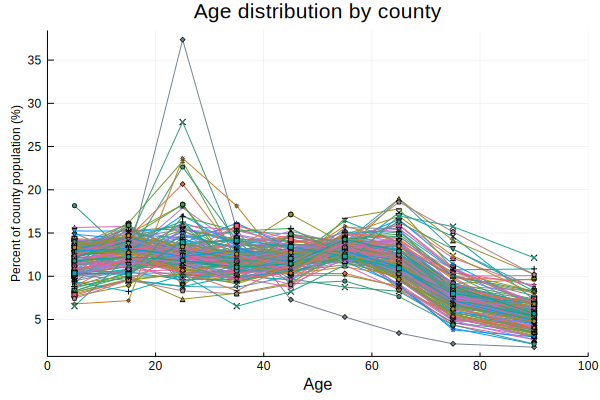

In [11]:
#Make plot of the age-distribution across counties
makeplot=1
if makeplot==1
gr()
plot(MiddleAge,100 .* convert(Array,(GA_county_size[1,3:11])),xlim=(0,100),title="Age distribution by county",
    ylabel="Percent of county population (%)",xlabel="Age",legend=false,yguidefontsize=8,markershape = :auto,markersize=2)
for aa=2:159
    plot!(MiddleAge,100 .* convert(Array,(GA_county_size[aa,3:11])),markershape = :auto,markersize=2)
end
savefig("./figures/GAagestructure.pdf")    
current()
end

In [12]:
#Basic epidemiology to apply across all patches
SocialDistancingInterventions=[1.0,0.75,0.5,0.25] #proportionalities to apply to both β_A and β_S (1.0 is no distancing)
β_A = 0.3 #asymptomatic transmission rate (per day)
β_S = 0.6 #symptomatic transmission rate (per day)
γ_e = (1.0/4.0) #mean exposed period (days)
γ_a = (1.0/6.0) #mean asymptomatic period (days)
γ_s = (1.0/6.0) #mean symptomatic period (days)
γ_h = (1.0/10.0) # mean hospitalised period (days)

p = [0.95, 0.95,0.9,0.8,0.7,0.6,0.4,0.2,0.2]  #fraction of cases that are asymptomatic
h = [0.1, 0.3, 1.2, 3.2, 4.9, 10.2, 16.6, 24.3, 27.3]./100; #fraction of cases that require a hospital visit (by age class)
ξ = [5, 5, 5, 5, 6.3, 12.2, 27.4, 43.2, 70.9]./100; #fraction of hospitalised cases that become critical and require critical care (by age class)
μ = 0.5.*ones(NumAgeClasses) #mortality fraction

ISMOVEFACTOR = 1.0 # how much to let Is people commute (must be 0-1)
w1 = 16/24 ; #fraction of time mixing with local pop.
w2 = 1.0 - w1 ;#fraction of time mixing with commuter pop.



#set parameter sets to use to initialise/drive the model
param = [1.0,β_A,β_S,p,γ_e,γ_a,γ_s,γ_h,h,ξ,μ,S_ind,E_ind,
    Ia_ind,Is_ind,Ihsub_ind,Ihcrit_ind,R_ind,D_ind,T_Hosp_ind,
    NumPatches,NumAgeClasses,patchstates,patchstatesALIVE,
    patchstatesMOVEABLE,w,wy,wo,transport,ISMOVEFACTOR,w1,w2]

singlenodepar =[1.0,β_A,β_S,p,γ_e,γ_a,γ_s,γ_h,h,ξ,μ,S_ind,E_ind,Ia_ind,Is_ind,R_ind,Ihsub_ind,Ihcrit_ind,D_ind,T_Hosp_ind]


20-element Array{Any,1}:
 1.0                                                                                                  
 0.3                                                                                                  
 0.6                                                                                                  
  [0.95, 0.95, 0.9, 0.8, 0.7, 0.6, 0.4, 0.2, 0.2]                                                     
 0.25                                                                                                 
 0.16666666666666666                                                                                  
 0.16666666666666666                                                                                  
 0.1                                                                                                  
  [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.243, 0.273]                                     
  [0.05, 0.05, 0.05, 0.05, 0.063, 0.122, 0.27399

 ### Set the initial conditions
 
We now have the ingredients. Now we need to mix in the ingredients.
Want to set initial conditions, being cognisant of the GA data.
Two main ways right now are: a simulation approach (CHOICE=5); and an "eigenvector" approach (CHOICE=7)

Simulation starts an epidemic in Fulton & Dougherty, then runs the model forward until deaths match up those recorded in GA data for each county one-by-one. The states in each county at these times are then patched together into an initial condition.

Eigenvector approach runs the model at the Georgia level till total deaths are matched. Then assigns the final vector of values proportionally across counties as an intial condition.

In [13]:
### Setting initial conditions
#Assign county age structured data to initial state 
GAPOP = sum(GA_county_size.POPSIZE) #total population of GA

MAT = convert(Array, (GA_county_size[:,3:(end-1)] .* GA_county_size.POPSIZE))
MAT2 = MAT ./ GAPOP
#sum(MAT2)#should = 1. Yes!
#MAT2 is the fraction of GA in eaah age class in each county.

#want to now assign MAT2 to initial vector u00
u00 = zeros(NumPatches*NumAgeClasses*NumEpiStates)

for aa = 1:NumPatches
        u00[(aa-1)*patchstates .+ S_ind] = MAT2[aa,:]
end

# load case data and figure out initial conditions
tspan = (0.0,3000.0)

#start epidemic with 1 exposed individual ages 20-29 in Fulton county ...
INDFult = findall(GA_county_size.FIP .== 13121)
INDFult=INDFult[1]#patch index
u00[S_ind[3] + patchstates*(INDFult-1)] = u00[S_ind[3] + patchstates*(INDFult-1)] - 1.0/GAPOP #minus from S
u00[E_ind[3] + patchstates*(INDFult-1)] = u00[E_ind[3] + patchstates*(INDFult-1)] + 1.0/GAPOP #add to E
#...and with 1 exposed individual ages 20-29 in Dougherty county
INDDougherty = findall(GA_county_size.FIP .== 13095) #dougherty county (Albany)
INDDougherty=INDDougherty[1]#patch index
u00[S_ind[3] + patchstates*(INDDougherty-1)] = u00[S_ind[3] + patchstates*(INDDougherty-1)] - 1.0/GAPOP #minus from S
u00[E_ind[3] + patchstates*(INDDougherty-1)] = u00[E_ind[3] + patchstates*(INDDougherty-1)] + 1.0/GAPOP #add to E
initu = u00

#set the ODE problem using this initial condition (1 infection in Dougherty and 1 infection in Fulton from people aged 20-29)
prob_init = ODEProblem(SpatialAgeStructuredEpidemiologicalModelMixAge!,initu,tspan,param)

#set an terminate integration affect.
affect!(integrator) = terminate!(integrator)

#state wide deaths and cases
TOT_deaths = sum(CasesbyCounty.deaths)/GAPOP
TOT_cases = sum(CasesbyCounty.cases)/GAPOP


#now use this information to initialise the model.
#Currently done with two options:
###CHOICES = 1 :  County simulation method (CSM)
#uses the initial outbreak defined above to find epi. distributions 
#in each county that hit death data in the GA data input county-by-county.
#These conditions are then merged together to make the final initial condition.
###CHOICES = 2 :  State level model (SLM)
#uses a non-spatial model for the whole of GA to find epi. distributions
# that hit deaths for the whole of GA. Then apportions these out to counties
# given the proportions of deaths recorded in each county.


if  CHOICES == 1
    ## County Simulation Method (CSM) ##
    
    #in general should use hospitalisations rather than cases, unless death available
    #case numbers highly likely to be underestimates
    Hprop = 0.2 #20.48% proportion of cases that are hospitalised - appears consistently around 20% (April 15)
    #- this is taken from Georgia Department of Public Health COVID-19 Daily Status Report
    #https://dph.georgia.gov/covid-19-daily-status-report
    
    #cases county by county
    for aa = 1:length(GA_county_size.FIP) #for each county in GA
    print(aa) #print index to help show progress
        
        IND = findall(CasesbyCounty.FIP .== GA_county_size.FIP[aa]) #find patch index
        DEATH = 0.0
        if length(IND) == 1 #ignore unknown category in case data
            DEATH = CasesbyCounty.deaths[IND[1]] #deaths recorded in this patch
            HOSP = Hprop * CasesbyCounty.cases[IND[1]] #hsopitalised assumed in this patch
        else
            HOSP = 0.5 # if no cases recorded. Assign some proportion to be hospitalised. Most likely non-zero.
        end
        
        #use this info. to simulate to epi. distributions in this patch
        
        if DEATH >0.0
            #If there are deaths simulate until the number of deaths is reached
             #set up callback to stop integration when number of cases reaches a threshold
            CaseThreshold = DEATH/GAPOP
            #sum of S in patch - (all in patch - thresh)
            condition(u,t,integrator)  = sum(u[D_ind .+ patchstates*(aa-1)]) - CaseThreshold  #this must be equal to zero at stopping condition
            affect!(integrator) = terminate!(integrator) 
            cb = ContinuousCallback(condition,affect!)
            #solve the initial spin up, checking for positivity and using callback definition 
            sol_init = solve(prob_init,Tsit5(), abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y), callback = cb)
            #assign end spinup states per county into new initial condition.
            END = sol_init.u[end]
            u00[(1+patchstates*(aa-1)):(patchstates*aa)] = END[(1+patchstates*(aa-1)):(patchstates*aa)]
        else
            #If no deaths simulate until the number hospitalised (both Ihsub and Ihcrit) is reached
            #set up callback to stop integration when number of cases reaches a threshold
            CaseThreshold = HOSP/GAPOP
            #sum of S in patch - (all in patch - thresh)
            condition2(u,t,integrator)  = sum(u[T_Hosp_ind .+ patchstates*(aa-1)]) - CaseThreshold  #this must be equal to zero at stopping condition
            #condition2(u,t,integrator)  = sum(u[[Ihsub_ind;Ihcrit_ind] .+ patchstates*(aa-1)]) - CaseThreshold  #this must be equal to zero at stopping condition
            affect2!(integrator) = terminate!(integrator) 
            cb2 = ContinuousCallback(condition2,affect2!)
            #solve the initial spin up, checking for positivity and using callback definition 
            sol_init = solve(prob_init,Tsit5(), abstol=1e-8,reltol=1e-8,saveat=1,isoutofdomain=(y,p,t)->any(x->x<0,y), callback = cb2)
            #assign end spinup states per county into new initial condition.
            END = sol_init.u[end]
            u00[(1+patchstates*(aa-1)):(patchstates*aa)] = END[(1+patchstates*(aa-1)):(patchstates*aa)]
        end
    end
   
elseif CHOICES == 2
    ## State Level Model (SLM) ##
    
    #1.set up initial conditions for a GA level model
    #Simple model to total deaths at state level. Then reapportion in the county model.
    Singleu0 = zeros(NumAgeClasses*NumEpiStates)
    Singleu0[S_ind] = sum(MAT2,dims=1)
    Singleu0[S_ind[3]] = Singleu0[S_ind[3]] - 1.0/GAPOP
    Singleu0[E_ind[3]] = 1.0/GAPOP  #seed the epidemic (1 person 20-29).

    prob_s_init = ODEProblem(SingleNode!,Singleu0,tspan,singlenodepar)

    CaseThreshold = TOT_deaths #as a fraction of GA pop.

    condition3(u,t,integrator)  = CaseThreshold - sum(u[D_ind])   #this must be equal to zero at stopping condition
    affect3!(integrator) = terminate!(integrator) 
    cb3 = ContinuousCallback(condition3,affect3!)

    #solve the initial spin up, checking for positivity and using callback definition 
    sol_s_init = solve(prob_s_init,Tsit5(), abstol=1e-8,reltol=1e-8,saveat=0.1,isoutofdomain=(y,p,t)->any(x->x<0,y), callback = cb3)

    #2. Now use this epi. distribution and assign it to each county
    START = sol_s_init.u[end] #initial distributions at state scale (age*epi classes)
    SumD = sum(START[D_ind])*GAPOP #sum of all deaths in model
    TOTD =  sum(CasesbyCounty.deaths) #total deaths in data
    TOTU =  sum(CasesbyCounty.deaths[CasesbyCounty.FIP.==-999]) #total deaths with unknown assignment
    L1 = length(GA_county_size.FIP) #all counties
    NUMUNKNOWN = sum(CasesbyCounty.FIP.==-999)
    L2 = length(CasesbyCounty.FIP)- NUMUNKNOWN - sum(CasesbyCounty.deaths .== 0) #num counties with cases
   
    for aa = 1:159
        countypop = GA_county_size.POPSIZE[aa]
        
        IND = findall(CasesbyCounty.FIP .== GA_county_size.FIP[aa]) #find patch index
        if length(IND) == 1 #ignore unknown category in case data
            D_county = 1.0 * CasesbyCounty.deaths[IND[1]]
            if D_county == 0.0
                D_county = TOTU/(L1-L2) #if this county has no recorded cases assign from the unknown pool.
            end
        else
            D_county = TOTU/(L1-L2) #if this county has no recorded cases assign from the unknown pool.
        end
        
        RATIO = 1.0*(D_county/TOTD) #county ratio - ratio of deaths in county to total
       
        NEW = START .* RATIO  .* GAPOP
        JAM = zeros(NumAgeClasses)
        Ages = MAT[aa,:] # age distribution in this county
        
        for bb=1:NumAgeClasses
           #calculate sum of all but S and cumulative Hosp. this age class
            JAM[bb] = sum(NEW[[E_ind[bb];Ia_ind[bb];Is_ind[bb];R_ind[bb];Ihsub_ind[bb];Ihcrit_ind[bb];D_ind[bb]]])
           #Now find what S for this age class should be
            NEW[S_ind[bb]] = Ages[bb] - JAM[bb]
        end
    
        NEW = NEW ./ GAPOP
        
        #check if any element in NEW is less than 0 - would indicate problems in preserving county demographics.
        if sum(isless.(NEW,0)) < 0
            print("WARNING. u LESS THAN 0")
            NEW[isless.(NEW,0)] = 0.0
        end
        
        #assign to intiial condition
        u00[(1+patchstates*(aa-1)):(patchstates*aa)] = NEW

    end
    
end

#assign end spinup states as new initial condition.



### Run the simulations

Now that the initial conditions are set, we are ready to bake the model.
Note that in the above conditions are set without any social distancing interventions. Currently, these are applied at time =0. That is here.
Here, we have a loop that goes through different social distancing levels (that reduce βS and βA); runs the model and saves the output to file.

## Forecasting phase

To run the forecasting phase, we train the data with no social distancing to March 28th using the non-spatial model; then we train the model to April 28th using a scenario with a 50% reduction in transmission rates. We then distribute to the spatial model, MAGE, and use this to forecast forward.

In [15]:
#Model Calibration phase for forecasting
SAVEFOLD = "SimulationOutput/28thApr_Run_int_1stMay"
CasesbyCounty2 = CSV.read("./data/7pm_28Apr2020.csv");
TODAY = Date(2020,4,28) #Date format of time 0


#1. Run state level model to March 28 with no SD
    TOT_deaths = sum(CasesbyCounty.deaths)/GAPOP
    TOT_deaths2 = sum(CasesbyCounty2.deaths)/GAPOP
    
    tspan = (0.0,5000.0)
    Singleu0 = zeros(NumAgeClasses*NumEpiStates)
    Singleu0[S_ind] = sum(MAT2,dims=1)
    Singleu0[S_ind[3]] = Singleu0[S_ind[3]] - 1.0/GAPOP
    Singleu0[E_ind[3]] = 1.0/GAPOP  #seed the epidemic (1 person 20-29).
    singlenodepar =[1.0,β_A,β_S,p,γ_e,γ_a,γ_s,γ_h,h,ξ,μ,S_ind,E_ind,Ia_ind,Is_ind,R_ind,Ihsub_ind,Ihcrit_ind,D_ind,T_Hosp_ind]

    prob_s_init = ODEProblem(SingleNode!,Singleu0,tspan,singlenodepar)

    CaseThreshold = TOT_deaths #as a fraction of GA pop.

    condition3(u,t,integrator)  = CaseThreshold - sum(u[D_ind])   #this must be equal to zero at stopping condition
    affect3!(integrator) = terminate!(integrator) 
    cb3 = ContinuousCallback(condition3,affect3!)

    #solve the initial spin up, checking for positivity and using callback definition 
    sol_s_init = solve(prob_s_init,Tsit5(), abstol=1e-8,reltol=1e-8,saveat=0.1,isoutofdomain=(y,p,t)->any(x->x<0,y), callback = cb3)


#2. Run state level model from this point foward to Apr 28 with 50% SD
    STAR = sol_s_init.u[end]
    singlenodepar =[0.5,β_A,β_S,p,γ_e,γ_a,γ_s,γ_h,h,ξ,μ,S_ind,E_ind,Ia_ind,Is_ind,R_ind,Ihsub_ind,Ihcrit_ind,D_ind,T_Hosp_ind]

    prob_t_init = ODEProblem(SingleNode!,STAR,tspan,singlenodepar)
    CaseThreshold = TOT_deaths2 #as a fraction of GA pop.

    condition3(u,t,integrator)  = CaseThreshold - sum(u[D_ind])   #this must be equal to zero at stopping condition
    affect3!(integrator) = terminate!(integrator) 
    cb3 = ContinuousCallback(condition3,affect3!)

    #solve the initial spin up, checking for positivity and using callback definition 
    sol_t_init = solve(prob_t_init,Tsit5(), abstol=1e-8,reltol=1e-8,saveat=0.1,isoutofdomain=(y,p,t)->any(x->x<0,y), callback = cb3)

#3. Distribute to counties
    u22 = zeros(NumPatches*NumAgeClasses*NumEpiStates)
    # Now use this epi. distribution and assign it to each county
    START = sol_t_init.u[end] #initial distributions at state scale (age*epi classes)
    SumD = sum(START[D_ind])*GAPOP #sum of all deaths in model
    TOTD =  sum(CasesbyCounty2.deaths) #total deaths in data
    TOTU =  sum(CasesbyCounty2.deaths[CasesbyCounty2.FIP.==-999]) #total deaths with unknown assignment
    L1 = length(GA_county_size.FIP) #all counties
    NUMUNKNOWN = sum(CasesbyCounty2.FIP.==-999)
    L2 = length(CasesbyCounty2.FIP)- NUMUNKNOWN - sum(CasesbyCounty2.deaths .== 0) #num counties with cases
   
    for aa = 1:159
        countypop = GA_county_size.POPSIZE[aa]
        
        IND = findall(CasesbyCounty2.FIP .== GA_county_size.FIP[aa]) #find patch index
        if length(IND) == 1 #ignore unknown category in case data
            D_county = 1.0 * CasesbyCounty2.deaths[IND[1]]
            if D_county == 0.0
                D_county = TOTU/(L1-L2) #if this county has no recorded cases assign from the unknown pool.
            end
        else
            D_county = TOTU/(L1-L2) #if this county has no recorded cases assign from the unknown pool.
        end
        
        RATIO = 1.0*(D_county/TOTD) #county ratio - ratio of deaths in county to total
       
        NEW = START .* RATIO  .* GAPOP
        JAM = zeros(NumAgeClasses)
        Ages = MAT[aa,:] # age distribution in this county
        
        for bb=1:NumAgeClasses
           #calculate sum of all but S and cumulative Hosp. this age class
            JAM[bb] = sum(NEW[[E_ind[bb];Ia_ind[bb];Is_ind[bb];R_ind[bb];Ihsub_ind[bb];Ihcrit_ind[bb];D_ind[bb]]])
           #Now find what S for this age class should be
            NEW[S_ind[bb]] = Ages[bb] - JAM[bb]
        end
    
        NEW = NEW ./ GAPOP
        
        #check if any element in NEW is less than 0 - would indicate problems in preserving county demographics.
        if sum(isless.(NEW,0)) < 0
            print("WARNING. u LESS THAN 0")
            NEW[isless.(NEW,0)] = 0.0
        end
        
        #assign to intiial condition
        u22[(1+patchstates*(aa-1)):(patchstates*aa)] = NEW

    end


#4. forecast forward from Apr 28 to May 1 at 50% SD, then introduce interventions


mkdir(SAVEFOLD)
for bb = 1:length(SocialDistancingInterventions)
    
    SAVEFOLD2 = string(SAVEFOLD,"/Social_",bb)
    
    #set parameters for this intervention
    pars = [0.5,β_A,β_S,p,γ_e,γ_a,γ_s,γ_h,h,ξ,μ,S_ind,E_ind,
    Ia_ind,Is_ind,Ihsub_ind,Ihcrit_ind,R_ind,D_ind,T_Hosp_ind,
    NumPatches,NumAgeClasses,patchstates,patchstatesALIVE,
    patchstatesMOVEABLE,w,wy,wo,transport,ISMOVEFACTOR,w1,w2]
   
    ##RELAXATION ON MAY 1st
    prob_a = ODEProblem(SpatialAgeStructuredEpidemiologicalModelMixAge!,u22,tspanrun,pars)
    condition(u,t,integrator) = t == 3.0  #3 days to May 1st
    affect!(integrator) = integrator.p[1] = SocialDistancingInterventions[bb]
    cb = DiscreteCallback(condition,affect!)
    SOL_a = solve(prob_a,Tsit5(),abstol=1e-8,reltol=1e-8,saveat=TIMERESOLUTION,isoutofdomain=(y,p,t)->any(x->x<0,y),callback = cb, tstops=[3.0],save_positions=(false,false))
    
    
    #save output

    WriteOutput!(PatchFIPS,PatchCounty,HospRegions,GAPOP,TODAY,TIMERESOLUTION,T_END,SOL_a,pars,SAVEFOLD2)
    
end

